In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./pretrained/trainy_pre.csv")
valy = pd.read_csv("./pretrained/valy_pre.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype'])
classes = len(np.unique(trainy['celltype']))
with open("./pretrained/label_encoder_pre.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype']))
y_val = pd.DataFrame(le.transform(valy['celltype']))
np.save('./pretrained/train_pre_label.npy', y_train)
np.save('./pretrained/val_pre_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./pretrained/checkpoint_model_pre.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("./pretrained/acc.txt", "w") as f:
        with open("./pretrained/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("./pretrained/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
batch_size = 32
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
net._fc.out_features = classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3


'Quadro RTX 8000'

In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./pretrained/train_pre.npy", "./pretrained/train_pre_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./pretrained/val_pre.npy", "./pretrained/val_pre_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
start = timer()

In [12]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 200,
                                                           early_patience = 30,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 2.232 | Accuracy: 6.250% 
[epoch:1, iter:2] Loss: 2.189 | Accuracy: 14.062% 
[epoch:1, iter:3] Loss: 2.161 | Accuracy: 17.708% 
[epoch:1, iter:4] Loss: 2.135 | Accuracy: 22.656% 
[epoch:1, iter:5] Loss: 2.108 | Accuracy: 27.500% 
[epoch:1, iter:6] Loss: 2.083 | Accuracy: 29.688% 
[epoch:1, iter:7] Loss: 2.052 | Accuracy: 33.482% 
[epoch:1, iter:8] Loss: 2.014 | Accuracy: 37.500% 
[epoch:1, iter:9] Loss: 1.977 | Accuracy: 39.931% 
[epoch:1, iter:10] Loss: 1.936 | Accuracy: 41.875% 
[epoch:1, iter:11] Loss: 1.894 | Accuracy: 44.318% 
[epoch:1, iter:12] Loss: 1.847 | Accuracy: 47.656% 
[epoch:1, iter:13] Loss: 1.808 | Accuracy: 49.038% 
[epoch:1, iter:14] Loss: 1.776 | Accuracy: 50.670% 
[epoch:1, iter:15] Loss: 1.744 | Accuracy: 52.500% 
[epoch:1, iter:16] Loss: 1.710 | Accuracy: 53.906% 
[epoch:1, iter:17] Loss: 1.673 | Accuracy: 55.699% 
[epoch:1, iter:18] Loss: 1.641 | Accuracy: 57.292% 
[epoch:1, iter:19] Loss: 1.602 | Accuracy: 59.211% 
[epoch:1, it

[epoch:3, iter:152] Loss: 0.583 | Accuracy: 95.312% 
[epoch:3, iter:153] Loss: 0.565 | Accuracy: 96.875% 
[epoch:3, iter:154] Loss: 0.571 | Accuracy: 96.875% 
[epoch:3, iter:155] Loss: 0.564 | Accuracy: 97.500% 
[epoch:3, iter:156] Loss: 0.565 | Accuracy: 97.396% 
[epoch:3, iter:157] Loss: 0.576 | Accuracy: 96.429% 
[epoch:3, iter:158] Loss: 0.576 | Accuracy: 96.484% 
[epoch:3, iter:159] Loss: 0.576 | Accuracy: 96.528% 
[epoch:3, iter:160] Loss: 0.578 | Accuracy: 96.562% 
[epoch:3, iter:161] Loss: 0.574 | Accuracy: 96.875% 
[epoch:3, iter:162] Loss: 0.584 | Accuracy: 96.615% 
[epoch:3, iter:163] Loss: 0.579 | Accuracy: 96.875% 
[epoch:3, iter:164] Loss: 0.581 | Accuracy: 96.875% 
[epoch:3, iter:165] Loss: 0.578 | Accuracy: 97.083% 
[epoch:3, iter:166] Loss: 0.573 | Accuracy: 97.266% 
[epoch:3, iter:167] Loss: 0.578 | Accuracy: 97.243% 
[epoch:3, iter:168] Loss: 0.584 | Accuracy: 97.049% 
[epoch:3, iter:169] Loss: 0.584 | Accuracy: 97.039% 
[epoch:3, iter:170] Loss: 0.590 | Accuracy: 96

[epoch:5, iter:302] Loss: 0.515 | Accuracy: 100.000% 
[epoch:5, iter:303] Loss: 0.531 | Accuracy: 98.958% 
[epoch:5, iter:304] Loss: 0.525 | Accuracy: 99.219% 
[epoch:5, iter:305] Loss: 0.522 | Accuracy: 99.375% 
[epoch:5, iter:306] Loss: 0.533 | Accuracy: 97.917% 
[epoch:5, iter:307] Loss: 0.530 | Accuracy: 98.214% 
[epoch:5, iter:308] Loss: 0.532 | Accuracy: 98.047% 
[epoch:5, iter:309] Loss: 0.529 | Accuracy: 98.264% 
[epoch:5, iter:310] Loss: 0.530 | Accuracy: 98.125% 
[epoch:5, iter:311] Loss: 0.530 | Accuracy: 98.011% 
[epoch:5, iter:312] Loss: 0.530 | Accuracy: 98.177% 
[epoch:5, iter:313] Loss: 0.534 | Accuracy: 98.077% 
[epoch:5, iter:314] Loss: 0.533 | Accuracy: 98.214% 
[epoch:5, iter:315] Loss: 0.534 | Accuracy: 98.125% 
[epoch:5, iter:316] Loss: 0.532 | Accuracy: 98.047% 
[epoch:5, iter:317] Loss: 0.531 | Accuracy: 98.162% 
[epoch:5, iter:318] Loss: 0.530 | Accuracy: 98.264% 
[epoch:5, iter:319] Loss: 0.530 | Accuracy: 98.191% 
[epoch:5, iter:320] Loss: 0.529 | Accuracy: 9


Epoch: 7
[epoch:7, iter:451] Loss: 0.574 | Accuracy: 96.875% 
[epoch:7, iter:452] Loss: 0.583 | Accuracy: 95.312% 
[epoch:7, iter:453] Loss: 0.555 | Accuracy: 96.875% 
[epoch:7, iter:454] Loss: 0.548 | Accuracy: 96.875% 
[epoch:7, iter:455] Loss: 0.541 | Accuracy: 97.500% 
[epoch:7, iter:456] Loss: 0.536 | Accuracy: 97.917% 
[epoch:7, iter:457] Loss: 0.533 | Accuracy: 97.768% 
[epoch:7, iter:458] Loss: 0.534 | Accuracy: 98.047% 
[epoch:7, iter:459] Loss: 0.534 | Accuracy: 97.917% 
[epoch:7, iter:460] Loss: 0.531 | Accuracy: 98.125% 
[epoch:7, iter:461] Loss: 0.536 | Accuracy: 97.727% 
[epoch:7, iter:462] Loss: 0.541 | Accuracy: 97.656% 
[epoch:7, iter:463] Loss: 0.539 | Accuracy: 97.837% 
[epoch:7, iter:464] Loss: 0.548 | Accuracy: 97.321% 
[epoch:7, iter:465] Loss: 0.546 | Accuracy: 97.500% 
[epoch:7, iter:466] Loss: 0.548 | Accuracy: 97.461% 
[epoch:7, iter:467] Loss: 0.545 | Accuracy: 97.610% 
[epoch:7, iter:468] Loss: 0.543 | Accuracy: 97.743% 
[epoch:7, iter:469] Loss: 0.541 | Ac


Epoch: 9
[epoch:9, iter:601] Loss: 0.614 | Accuracy: 93.750% 
[epoch:9, iter:602] Loss: 0.560 | Accuracy: 96.875% 
[epoch:9, iter:603] Loss: 0.543 | Accuracy: 97.917% 
[epoch:9, iter:604] Loss: 0.535 | Accuracy: 98.438% 
[epoch:9, iter:605] Loss: 0.538 | Accuracy: 98.125% 
[epoch:9, iter:606] Loss: 0.542 | Accuracy: 97.917% 
[epoch:9, iter:607] Loss: 0.539 | Accuracy: 98.214% 
[epoch:9, iter:608] Loss: 0.535 | Accuracy: 98.438% 
[epoch:9, iter:609] Loss: 0.531 | Accuracy: 98.611% 
[epoch:9, iter:610] Loss: 0.538 | Accuracy: 98.125% 
[epoch:9, iter:611] Loss: 0.534 | Accuracy: 98.295% 
[epoch:9, iter:612] Loss: 0.532 | Accuracy: 98.438% 
[epoch:9, iter:613] Loss: 0.530 | Accuracy: 98.558% 
[epoch:9, iter:614] Loss: 0.535 | Accuracy: 98.438% 
[epoch:9, iter:615] Loss: 0.533 | Accuracy: 98.542% 
[epoch:9, iter:616] Loss: 0.531 | Accuracy: 98.633% 
[epoch:9, iter:617] Loss: 0.532 | Accuracy: 98.529% 
[epoch:9, iter:618] Loss: 0.530 | Accuracy: 98.611% 
[epoch:9, iter:619] Loss: 0.529 | Ac


Epoch: 11
[epoch:11, iter:751] Loss: 0.498 | Accuracy: 100.000% 
[epoch:11, iter:752] Loss: 0.496 | Accuracy: 100.000% 
[epoch:11, iter:753] Loss: 0.495 | Accuracy: 100.000% 
[epoch:11, iter:754] Loss: 0.494 | Accuracy: 100.000% 
[epoch:11, iter:755] Loss: 0.496 | Accuracy: 100.000% 
[epoch:11, iter:756] Loss: 0.496 | Accuracy: 100.000% 
[epoch:11, iter:757] Loss: 0.496 | Accuracy: 100.000% 
[epoch:11, iter:758] Loss: 0.497 | Accuracy: 100.000% 
[epoch:11, iter:759] Loss: 0.497 | Accuracy: 100.000% 
[epoch:11, iter:760] Loss: 0.500 | Accuracy: 99.688% 
[epoch:11, iter:761] Loss: 0.499 | Accuracy: 99.716% 
[epoch:11, iter:762] Loss: 0.500 | Accuracy: 99.740% 
[epoch:11, iter:763] Loss: 0.504 | Accuracy: 99.519% 
[epoch:11, iter:764] Loss: 0.503 | Accuracy: 99.554% 
[epoch:11, iter:765] Loss: 0.507 | Accuracy: 99.375% 
[epoch:11, iter:766] Loss: 0.507 | Accuracy: 99.414% 
[epoch:11, iter:767] Loss: 0.506 | Accuracy: 99.449% 
[epoch:11, iter:768] Loss: 0.506 | Accuracy: 99.479% 
[epoch:1

[epoch:12, iter:900] Loss: 0.515 | Accuracy: 99.662% 
Waiting Test!
EPOCH=012, Loss: 1.041, Accuracy= 77.303%
Training complete in 0m 14s
EarlyStopping counter: 1 out of 30

Epoch: 13
[epoch:13, iter:901] Loss: 0.659 | Accuracy: 96.875% 
[epoch:13, iter:902] Loss: 0.588 | Accuracy: 98.438% 
[epoch:13, iter:903] Loss: 0.565 | Accuracy: 98.958% 
[epoch:13, iter:904] Loss: 0.553 | Accuracy: 99.219% 
[epoch:13, iter:905] Loss: 0.542 | Accuracy: 99.375% 
[epoch:13, iter:906] Loss: 0.535 | Accuracy: 99.479% 
[epoch:13, iter:907] Loss: 0.530 | Accuracy: 99.554% 
[epoch:13, iter:908] Loss: 0.526 | Accuracy: 99.609% 
[epoch:13, iter:909] Loss: 0.523 | Accuracy: 99.653% 
[epoch:13, iter:910] Loss: 0.521 | Accuracy: 99.688% 
[epoch:13, iter:911] Loss: 0.519 | Accuracy: 99.716% 
[epoch:13, iter:912] Loss: 0.518 | Accuracy: 99.740% 
[epoch:13, iter:913] Loss: 0.517 | Accuracy: 99.760% 
[epoch:13, iter:914] Loss: 0.515 | Accuracy: 99.777% 
[epoch:13, iter:915] Loss: 0.514 | Accuracy: 99.792% 
[epoch

[epoch:14, iter:1047] Loss: 0.500 | Accuracy: 99.609% 
[epoch:14, iter:1048] Loss: 0.500 | Accuracy: 99.572% 
[epoch:14, iter:1049] Loss: 0.500 | Accuracy: 99.578% 
[epoch:14, iter:1050] Loss: 0.500 | Accuracy: 99.578% 
Waiting Test!
EPOCH=014, Loss: 0.665, Accuracy= 94.408%
Training complete in 0m 14s
Validation accuracy increased (93.421053 --> 94.407895).  Saving model ...

Epoch: 15
[epoch:15, iter:1051] Loss: 0.524 | Accuracy: 96.875% 
[epoch:15, iter:1052] Loss: 0.511 | Accuracy: 98.438% 
[epoch:15, iter:1053] Loss: 0.506 | Accuracy: 98.958% 
[epoch:15, iter:1054] Loss: 0.516 | Accuracy: 98.438% 
[epoch:15, iter:1055] Loss: 0.514 | Accuracy: 98.750% 
[epoch:15, iter:1056] Loss: 0.510 | Accuracy: 98.958% 
[epoch:15, iter:1057] Loss: 0.507 | Accuracy: 99.107% 
[epoch:15, iter:1058] Loss: 0.506 | Accuracy: 99.219% 
[epoch:15, iter:1059] Loss: 0.504 | Accuracy: 99.306% 
[epoch:15, iter:1060] Loss: 0.503 | Accuracy: 99.375% 
[epoch:15, iter:1061] Loss: 0.502 | Accuracy: 99.432% 
[epoc

[epoch:16, iter:1191] Loss: 0.511 | Accuracy: 99.195% 
[epoch:16, iter:1192] Loss: 0.511 | Accuracy: 99.207% 
[epoch:16, iter:1193] Loss: 0.510 | Accuracy: 99.219% 
[epoch:16, iter:1194] Loss: 0.511 | Accuracy: 99.185% 
[epoch:16, iter:1195] Loss: 0.511 | Accuracy: 99.196% 
[epoch:16, iter:1196] Loss: 0.511 | Accuracy: 99.164% 
[epoch:16, iter:1197] Loss: 0.511 | Accuracy: 99.175% 
[epoch:16, iter:1198] Loss: 0.511 | Accuracy: 99.187% 
[epoch:16, iter:1199] Loss: 0.511 | Accuracy: 99.155% 
[epoch:16, iter:1200] Loss: 0.527 | Accuracy: 99.114% 
Waiting Test!
EPOCH=016, Loss: 0.882, Accuracy= 88.487%
Training complete in 0m 14s
EarlyStopping counter: 2 out of 30

Epoch: 17
[epoch:17, iter:1201] Loss: 0.647 | Accuracy: 93.750% 
[epoch:17, iter:1202] Loss: 0.591 | Accuracy: 96.875% 
[epoch:17, iter:1203] Loss: 0.573 | Accuracy: 96.875% 
[epoch:17, iter:1204] Loss: 0.573 | Accuracy: 96.875% 
[epoch:17, iter:1205] Loss: 0.588 | Accuracy: 96.250% 
[epoch:17, iter:1206] Loss: 0.610 | Accuracy:

[epoch:18, iter:1337] Loss: 0.510 | Accuracy: 99.194% 
[epoch:18, iter:1338] Loss: 0.510 | Accuracy: 99.206% 
[epoch:18, iter:1339] Loss: 0.511 | Accuracy: 99.121% 
[epoch:18, iter:1340] Loss: 0.511 | Accuracy: 99.135% 
[epoch:18, iter:1341] Loss: 0.511 | Accuracy: 99.148% 
[epoch:18, iter:1342] Loss: 0.510 | Accuracy: 99.160% 
[epoch:18, iter:1343] Loss: 0.510 | Accuracy: 99.173% 
[epoch:18, iter:1344] Loss: 0.510 | Accuracy: 99.185% 
[epoch:18, iter:1345] Loss: 0.510 | Accuracy: 99.152% 
[epoch:18, iter:1346] Loss: 0.510 | Accuracy: 99.164% 
[epoch:18, iter:1347] Loss: 0.510 | Accuracy: 99.175% 
[epoch:18, iter:1348] Loss: 0.510 | Accuracy: 99.187% 
[epoch:18, iter:1349] Loss: 0.509 | Accuracy: 99.198% 
[epoch:18, iter:1350] Loss: 0.509 | Accuracy: 99.198% 
Waiting Test!
EPOCH=018, Loss: 0.748, Accuracy= 92.105%
Epoch 00018: reducing learning rate of group 0 to 2.1000e-04.
Training complete in 0m 13s
EarlyStopping counter: 4 out of 30

Epoch: 19
[epoch:19, iter:1351] Loss: 0.491 | Ac

[epoch:20, iter:1481] Loss: 0.491 | Accuracy: 99.888% 
[epoch:20, iter:1482] Loss: 0.491 | Accuracy: 99.890% 
[epoch:20, iter:1483] Loss: 0.491 | Accuracy: 99.892% 
[epoch:20, iter:1484] Loss: 0.491 | Accuracy: 99.894% 
[epoch:20, iter:1485] Loss: 0.491 | Accuracy: 99.896% 
[epoch:20, iter:1486] Loss: 0.491 | Accuracy: 99.898% 
[epoch:20, iter:1487] Loss: 0.492 | Accuracy: 99.849% 
[epoch:20, iter:1488] Loss: 0.492 | Accuracy: 99.851% 
[epoch:20, iter:1489] Loss: 0.492 | Accuracy: 99.854% 
[epoch:20, iter:1490] Loss: 0.492 | Accuracy: 99.856% 
[epoch:20, iter:1491] Loss: 0.492 | Accuracy: 99.858% 
[epoch:20, iter:1492] Loss: 0.493 | Accuracy: 99.813% 
[epoch:20, iter:1493] Loss: 0.493 | Accuracy: 99.816% 
[epoch:20, iter:1494] Loss: 0.493 | Accuracy: 99.819% 
[epoch:20, iter:1495] Loss: 0.493 | Accuracy: 99.821% 
[epoch:20, iter:1496] Loss: 0.493 | Accuracy: 99.824% 
[epoch:20, iter:1497] Loss: 0.493 | Accuracy: 99.826% 
[epoch:20, iter:1498] Loss: 0.493 | Accuracy: 99.829% 
[epoch:20,

[epoch:22, iter:1624] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1625] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1626] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1627] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1628] Loss: 0.489 | Accuracy: 100.000% 
[epoch:22, iter:1629] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1630] Loss: 0.489 | Accuracy: 100.000% 
[epoch:22, iter:1631] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1632] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1633] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1634] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1635] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1636] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1637] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1638] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1639] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1640] Loss: 0.490 | Accuracy: 100.000% 
[epoch:22, iter:1641] Loss: 0.489 | Accuracy: 10

[epoch:24, iter:1768] Loss: 0.490 | Accuracy: 99.855% 
[epoch:24, iter:1769] Loss: 0.490 | Accuracy: 99.858% 
[epoch:24, iter:1770] Loss: 0.490 | Accuracy: 99.861% 
[epoch:24, iter:1771] Loss: 0.490 | Accuracy: 99.864% 
[epoch:24, iter:1772] Loss: 0.490 | Accuracy: 99.867% 
[epoch:24, iter:1773] Loss: 0.491 | Accuracy: 99.870% 
[epoch:24, iter:1774] Loss: 0.491 | Accuracy: 99.872% 
[epoch:24, iter:1775] Loss: 0.491 | Accuracy: 99.875% 
[epoch:24, iter:1776] Loss: 0.491 | Accuracy: 99.877% 
[epoch:24, iter:1777] Loss: 0.491 | Accuracy: 99.880% 
[epoch:24, iter:1778] Loss: 0.491 | Accuracy: 99.882% 
[epoch:24, iter:1779] Loss: 0.491 | Accuracy: 99.884% 
[epoch:24, iter:1780] Loss: 0.491 | Accuracy: 99.886% 
[epoch:24, iter:1781] Loss: 0.491 | Accuracy: 99.888% 
[epoch:24, iter:1782] Loss: 0.491 | Accuracy: 99.890% 
[epoch:24, iter:1783] Loss: 0.491 | Accuracy: 99.892% 
[epoch:24, iter:1784] Loss: 0.491 | Accuracy: 99.894% 
[epoch:24, iter:1785] Loss: 0.491 | Accuracy: 99.896% 
[epoch:24,

[epoch:26, iter:1912] Loss: 0.490 | Accuracy: 99.916% 
[epoch:26, iter:1913] Loss: 0.490 | Accuracy: 99.918% 
[epoch:26, iter:1914] Loss: 0.490 | Accuracy: 99.920% 
[epoch:26, iter:1915] Loss: 0.490 | Accuracy: 99.922% 
[epoch:26, iter:1916] Loss: 0.490 | Accuracy: 99.924% 
[epoch:26, iter:1917] Loss: 0.490 | Accuracy: 99.926% 
[epoch:26, iter:1918] Loss: 0.490 | Accuracy: 99.927% 
[epoch:26, iter:1919] Loss: 0.490 | Accuracy: 99.929% 
[epoch:26, iter:1920] Loss: 0.490 | Accuracy: 99.931% 
[epoch:26, iter:1921] Loss: 0.490 | Accuracy: 99.932% 
[epoch:26, iter:1922] Loss: 0.490 | Accuracy: 99.934% 
[epoch:26, iter:1923] Loss: 0.490 | Accuracy: 99.935% 
[epoch:26, iter:1924] Loss: 0.490 | Accuracy: 99.936% 
[epoch:26, iter:1925] Loss: 0.490 | Accuracy: 99.938% 
[epoch:26, iter:1926] Loss: 0.490 | Accuracy: 99.939% 
[epoch:26, iter:1927] Loss: 0.490 | Accuracy: 99.940% 
[epoch:26, iter:1928] Loss: 0.490 | Accuracy: 99.941% 
[epoch:26, iter:1929] Loss: 0.490 | Accuracy: 99.942% 
[epoch:26,

[epoch:28, iter:2056] Loss: 0.502 | Accuracy: 99.597% 
[epoch:28, iter:2057] Loss: 0.501 | Accuracy: 99.609% 
[epoch:28, iter:2058] Loss: 0.501 | Accuracy: 99.621% 
[epoch:28, iter:2059] Loss: 0.501 | Accuracy: 99.632% 
[epoch:28, iter:2060] Loss: 0.500 | Accuracy: 99.643% 
[epoch:28, iter:2061] Loss: 0.500 | Accuracy: 99.653% 
[epoch:28, iter:2062] Loss: 0.500 | Accuracy: 99.662% 
[epoch:28, iter:2063] Loss: 0.499 | Accuracy: 99.671% 
[epoch:28, iter:2064] Loss: 0.499 | Accuracy: 99.679% 
[epoch:28, iter:2065] Loss: 0.499 | Accuracy: 99.688% 
[epoch:28, iter:2066] Loss: 0.499 | Accuracy: 99.695% 
[epoch:28, iter:2067] Loss: 0.499 | Accuracy: 99.702% 
[epoch:28, iter:2068] Loss: 0.498 | Accuracy: 99.709% 
[epoch:28, iter:2069] Loss: 0.498 | Accuracy: 99.716% 
[epoch:28, iter:2070] Loss: 0.498 | Accuracy: 99.722% 
[epoch:28, iter:2071] Loss: 0.498 | Accuracy: 99.728% 
[epoch:28, iter:2072] Loss: 0.498 | Accuracy: 99.734% 
[epoch:28, iter:2073] Loss: 0.498 | Accuracy: 99.740% 
[epoch:28,

[epoch:30, iter:2200] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2201] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2202] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2203] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2204] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2205] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2206] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2207] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2208] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2209] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2210] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2211] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2212] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2213] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2214] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2215] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2216] Loss: 0.490 | Accuracy: 100.000% 
[epoch:30, iter:2217] Loss: 0.490 | Accuracy: 10

[epoch:32, iter:2343] Loss: 0.491 | Accuracy: 99.826% 
[epoch:32, iter:2344] Loss: 0.491 | Accuracy: 99.836% 
[epoch:32, iter:2345] Loss: 0.491 | Accuracy: 99.844% 
[epoch:32, iter:2346] Loss: 0.491 | Accuracy: 99.851% 
[epoch:32, iter:2347] Loss: 0.491 | Accuracy: 99.858% 
[epoch:32, iter:2348] Loss: 0.490 | Accuracy: 99.864% 
[epoch:32, iter:2349] Loss: 0.490 | Accuracy: 99.870% 
[epoch:32, iter:2350] Loss: 0.490 | Accuracy: 99.875% 
[epoch:32, iter:2351] Loss: 0.490 | Accuracy: 99.880% 
[epoch:32, iter:2352] Loss: 0.490 | Accuracy: 99.884% 
[epoch:32, iter:2353] Loss: 0.490 | Accuracy: 99.888% 
[epoch:32, iter:2354] Loss: 0.490 | Accuracy: 99.892% 
[epoch:32, iter:2355] Loss: 0.490 | Accuracy: 99.896% 
[epoch:32, iter:2356] Loss: 0.490 | Accuracy: 99.899% 
[epoch:32, iter:2357] Loss: 0.490 | Accuracy: 99.902% 
[epoch:32, iter:2358] Loss: 0.490 | Accuracy: 99.905% 
[epoch:32, iter:2359] Loss: 0.490 | Accuracy: 99.908% 
[epoch:32, iter:2360] Loss: 0.490 | Accuracy: 99.911% 
[epoch:32,

[epoch:34, iter:2487] Loss: 0.493 | Accuracy: 99.740% 
[epoch:34, iter:2488] Loss: 0.492 | Accuracy: 99.760% 
[epoch:34, iter:2489] Loss: 0.492 | Accuracy: 99.777% 
[epoch:34, iter:2490] Loss: 0.492 | Accuracy: 99.792% 
[epoch:34, iter:2491] Loss: 0.492 | Accuracy: 99.805% 
[epoch:34, iter:2492] Loss: 0.491 | Accuracy: 99.816% 
[epoch:34, iter:2493] Loss: 0.491 | Accuracy: 99.826% 
[epoch:34, iter:2494] Loss: 0.491 | Accuracy: 99.836% 
[epoch:34, iter:2495] Loss: 0.491 | Accuracy: 99.844% 
[epoch:34, iter:2496] Loss: 0.491 | Accuracy: 99.851% 
[epoch:34, iter:2497] Loss: 0.491 | Accuracy: 99.858% 
[epoch:34, iter:2498] Loss: 0.491 | Accuracy: 99.864% 
[epoch:34, iter:2499] Loss: 0.491 | Accuracy: 99.870% 
[epoch:34, iter:2500] Loss: 0.491 | Accuracy: 99.875% 
[epoch:34, iter:2501] Loss: 0.491 | Accuracy: 99.880% 
[epoch:34, iter:2502] Loss: 0.491 | Accuracy: 99.884% 
[epoch:34, iter:2503] Loss: 0.490 | Accuracy: 99.888% 
[epoch:34, iter:2504] Loss: 0.491 | Accuracy: 99.892% 
[epoch:34,

[epoch:36, iter:2632] Loss: 0.490 | Accuracy: 100.000% 
[epoch:36, iter:2633] Loss: 0.494 | Accuracy: 99.609% 
[epoch:36, iter:2634] Loss: 0.493 | Accuracy: 99.653% 
[epoch:36, iter:2635] Loss: 0.493 | Accuracy: 99.688% 
[epoch:36, iter:2636] Loss: 0.493 | Accuracy: 99.716% 
[epoch:36, iter:2637] Loss: 0.492 | Accuracy: 99.740% 
[epoch:36, iter:2638] Loss: 0.493 | Accuracy: 99.760% 
[epoch:36, iter:2639] Loss: 0.492 | Accuracy: 99.777% 
[epoch:36, iter:2640] Loss: 0.492 | Accuracy: 99.792% 
[epoch:36, iter:2641] Loss: 0.492 | Accuracy: 99.805% 
[epoch:36, iter:2642] Loss: 0.492 | Accuracy: 99.816% 
[epoch:36, iter:2643] Loss: 0.491 | Accuracy: 99.826% 
[epoch:36, iter:2644] Loss: 0.491 | Accuracy: 99.836% 
[epoch:36, iter:2645] Loss: 0.491 | Accuracy: 99.844% 
[epoch:36, iter:2646] Loss: 0.491 | Accuracy: 99.851% 
[epoch:36, iter:2647] Loss: 0.491 | Accuracy: 99.858% 
[epoch:36, iter:2648] Loss: 0.491 | Accuracy: 99.864% 
[epoch:36, iter:2649] Loss: 0.491 | Accuracy: 99.870% 
[epoch:36

[epoch:38, iter:2777] Loss: 0.490 | Accuracy: 100.000% 
[epoch:38, iter:2778] Loss: 0.489 | Accuracy: 100.000% 
[epoch:38, iter:2779] Loss: 0.489 | Accuracy: 100.000% 
[epoch:38, iter:2780] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2781] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2782] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2783] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2784] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2785] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2786] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2787] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2788] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2789] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2790] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2791] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2792] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2793] Loss: 0.488 | Accuracy: 100.000% 
[epoch:38, iter:2794] Loss: 0.488 | Accuracy: 10

[epoch:39, iter:2921] Loss: 0.488 | Accuracy: 100.000% 
[epoch:39, iter:2922] Loss: 0.488 | Accuracy: 100.000% 
[epoch:39, iter:2923] Loss: 0.488 | Accuracy: 100.000% 
[epoch:39, iter:2924] Loss: 0.488 | Accuracy: 100.000% 
[epoch:39, iter:2925] Loss: 0.488 | Accuracy: 100.000% 
Waiting Test!
EPOCH=039, Loss: 0.653, Accuracy= 94.737%
Training complete in 0m 12s
EarlyStopping counter: 18 out of 30

Epoch: 40
[epoch:40, iter:2926] Loss: 0.490 | Accuracy: 100.000% 
[epoch:40, iter:2927] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2928] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2929] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2930] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2931] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2932] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2933] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2934] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2935] Loss: 0.488 | Accuracy: 100.000% 
[epoch:40, iter:2936] Loss: 0

[epoch:41, iter:3065] Loss: 0.489 | Accuracy: 99.952% 
[epoch:41, iter:3066] Loss: 0.489 | Accuracy: 99.953% 
[epoch:41, iter:3067] Loss: 0.489 | Accuracy: 99.953% 
[epoch:41, iter:3068] Loss: 0.489 | Accuracy: 99.954% 
[epoch:41, iter:3069] Loss: 0.489 | Accuracy: 99.955% 
[epoch:41, iter:3070] Loss: 0.489 | Accuracy: 99.955% 
[epoch:41, iter:3071] Loss: 0.489 | Accuracy: 99.956% 
[epoch:41, iter:3072] Loss: 0.489 | Accuracy: 99.957% 
[epoch:41, iter:3073] Loss: 0.489 | Accuracy: 99.957% 
[epoch:41, iter:3074] Loss: 0.489 | Accuracy: 99.958% 
[epoch:41, iter:3075] Loss: 0.489 | Accuracy: 99.958% 
Waiting Test!
EPOCH=041, Loss: 0.646, Accuracy= 94.408%
Epoch 00041: reducing learning rate of group 0 to 3.5295e-05.
Training complete in 0m 13s
EarlyStopping counter: 20 out of 30

Epoch: 42
[epoch:42, iter:3076] Loss: 0.488 | Accuracy: 100.000% 
[epoch:42, iter:3077] Loss: 0.487 | Accuracy: 100.000% 
[epoch:42, iter:3078] Loss: 0.487 | Accuracy: 100.000% 
[epoch:42, iter:3079] Loss: 0.488 

[epoch:43, iter:3207] Loss: 0.488 | Accuracy: 99.945% 
[epoch:43, iter:3208] Loss: 0.488 | Accuracy: 99.946% 
[epoch:43, iter:3209] Loss: 0.488 | Accuracy: 99.947% 
[epoch:43, iter:3210] Loss: 0.488 | Accuracy: 99.948% 
[epoch:43, iter:3211] Loss: 0.488 | Accuracy: 99.949% 
[epoch:43, iter:3212] Loss: 0.488 | Accuracy: 99.950% 
[epoch:43, iter:3213] Loss: 0.488 | Accuracy: 99.950% 
[epoch:43, iter:3214] Loss: 0.488 | Accuracy: 99.951% 
[epoch:43, iter:3215] Loss: 0.488 | Accuracy: 99.952% 
[epoch:43, iter:3216] Loss: 0.488 | Accuracy: 99.953% 
[epoch:43, iter:3217] Loss: 0.488 | Accuracy: 99.953% 
[epoch:43, iter:3218] Loss: 0.488 | Accuracy: 99.954% 
[epoch:43, iter:3219] Loss: 0.488 | Accuracy: 99.955% 
[epoch:43, iter:3220] Loss: 0.488 | Accuracy: 99.955% 
[epoch:43, iter:3221] Loss: 0.488 | Accuracy: 99.956% 
[epoch:43, iter:3222] Loss: 0.488 | Accuracy: 99.957% 
[epoch:43, iter:3223] Loss: 0.488 | Accuracy: 99.957% 
[epoch:43, iter:3224] Loss: 0.488 | Accuracy: 99.958% 
[epoch:43,

[epoch:45, iter:3349] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3350] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3351] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3352] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3353] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3354] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3355] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3356] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3357] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3358] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3359] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3360] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3361] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3362] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3363] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3364] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3365] Loss: 0.488 | Accuracy: 100.000% 
[epoch:45, iter:3366] Loss: 0.488 | Accuracy: 10

[epoch:47, iter:3490] Loss: 0.489 | Accuracy: 99.922% 
[epoch:47, iter:3491] Loss: 0.489 | Accuracy: 99.924% 
[epoch:47, iter:3492] Loss: 0.489 | Accuracy: 99.926% 
[epoch:47, iter:3493] Loss: 0.489 | Accuracy: 99.927% 
[epoch:47, iter:3494] Loss: 0.489 | Accuracy: 99.929% 
[epoch:47, iter:3495] Loss: 0.489 | Accuracy: 99.931% 
[epoch:47, iter:3496] Loss: 0.489 | Accuracy: 99.932% 
[epoch:47, iter:3497] Loss: 0.489 | Accuracy: 99.934% 
[epoch:47, iter:3498] Loss: 0.489 | Accuracy: 99.935% 
[epoch:47, iter:3499] Loss: 0.489 | Accuracy: 99.936% 
[epoch:47, iter:3500] Loss: 0.489 | Accuracy: 99.938% 
[epoch:47, iter:3501] Loss: 0.489 | Accuracy: 99.939% 
[epoch:47, iter:3502] Loss: 0.489 | Accuracy: 99.940% 
[epoch:47, iter:3503] Loss: 0.489 | Accuracy: 99.941% 
[epoch:47, iter:3504] Loss: 0.489 | Accuracy: 99.942% 
[epoch:47, iter:3505] Loss: 0.489 | Accuracy: 99.943% 
[epoch:47, iter:3506] Loss: 0.489 | Accuracy: 99.944% 
[epoch:47, iter:3507] Loss: 0.489 | Accuracy: 99.945% 
[epoch:47,

[epoch:49, iter:3633] Loss: 0.490 | Accuracy: 99.905% 
[epoch:49, iter:3634] Loss: 0.489 | Accuracy: 99.908% 
[epoch:49, iter:3635] Loss: 0.489 | Accuracy: 99.911% 
[epoch:49, iter:3636] Loss: 0.489 | Accuracy: 99.913% 
[epoch:49, iter:3637] Loss: 0.489 | Accuracy: 99.916% 
[epoch:49, iter:3638] Loss: 0.489 | Accuracy: 99.918% 
[epoch:49, iter:3639] Loss: 0.489 | Accuracy: 99.920% 
[epoch:49, iter:3640] Loss: 0.489 | Accuracy: 99.922% 
[epoch:49, iter:3641] Loss: 0.490 | Accuracy: 99.848% 
[epoch:49, iter:3642] Loss: 0.490 | Accuracy: 99.851% 
[epoch:49, iter:3643] Loss: 0.490 | Accuracy: 99.855% 
[epoch:49, iter:3644] Loss: 0.490 | Accuracy: 99.858% 
[epoch:49, iter:3645] Loss: 0.490 | Accuracy: 99.861% 
[epoch:49, iter:3646] Loss: 0.490 | Accuracy: 99.864% 
[epoch:49, iter:3647] Loss: 0.490 | Accuracy: 99.867% 
[epoch:49, iter:3648] Loss: 0.490 | Accuracy: 99.870% 
[epoch:49, iter:3649] Loss: 0.489 | Accuracy: 99.872% 
[epoch:49, iter:3650] Loss: 0.489 | Accuracy: 99.875% 
[epoch:49,

[epoch:51, iter:3776] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3777] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3778] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3779] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3780] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3781] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3782] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3783] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3784] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3785] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3786] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3787] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3788] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3789] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3790] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3791] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3792] Loss: 0.488 | Accuracy: 100.000% 
[epoch:51, iter:3793] Loss: 0.488 | Accuracy: 10

In [13]:
end = timer()
print(end - start)

676.1945205032825


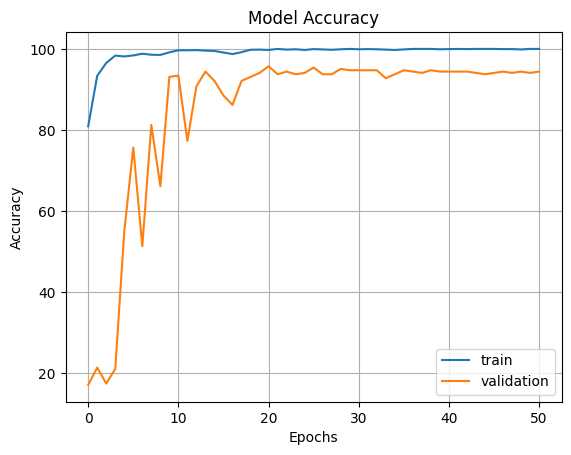

In [14]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

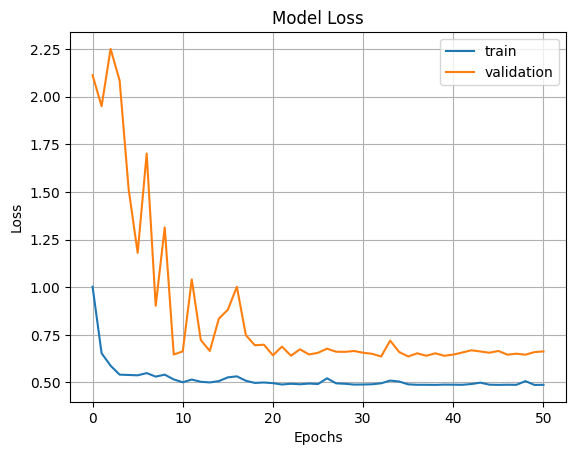

In [15]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [17]:
test = MyTestSet("./pretrained/testy_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrained/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [19]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

real_label = pd.read_csv("./pretrained/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype                
type B pancreatic cell      282
pancreatic acinar cell      121
pancreatic A cell           109
pancreatic ductal cell       66
endothelial cell             43
pancreatic D cell            40
leukocyte                    25
pancreatic PP cell           15
pancreatic stellate cell     10
dtype: int64

In [20]:
file = open("./pretrained/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

type B pancreatic cell      274
pancreatic acinar cell      123
pancreatic A cell           116
pancreatic ductal cell       65
pancreatic D cell            44
endothelial cell             41
leukocyte                    25
pancreatic PP cell           13
pancreatic stellate cell     10
dtype: int64

In [22]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.958, ARI = 0.911
